# Прогнозирование стоимости автомобиля по характеристикам, описанию и фото


# Подготовительные операции

In [1]:
# Установим недостающие библиотеки
!pip install -q --upgrade pip
!pip install -q tensorflow
!pip install -q albumentations
!pip install -q pandas-profiling
!pip install -q pymorphy2
!pip install -q pymorphy2-dicts
!pip install -q DAWG-Python

In [2]:
# Импортируем нужные библиотеки
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, PowerTransformer

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_addons as tfa

import albumentations

from scipy import stats

from tqdm.notebook import tqdm

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

import seaborn as sns

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
# Зададим функции расчета MAPE и логарифмирования признаков и таргета
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def log_price(y):
    return np.log(y)

def orig_price(y):
    return np.exp(y)

In [4]:
# Фиксируем RANDOM_SEED
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
!pip freeze > requirements.txt

# Подгружаем данные

In [6]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [7]:
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [8]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# Заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# Округлим
predicts = (predicts // 1000) * 1000

# Оценим точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

С помощью пакета Pandas Profiling легко осуществляем EDA анализ датасета и получаем все нужные нам характеристики в одном месте.

In [9]:
profile = ProfileReport(train, title='Pandas Profiling Report',)

In [10]:
profile.to_notebook_iframe()

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [11]:
profile.to_file("pandas_report.html")

Итого мы видим:
* В признаках **descriprion, enginePower, model_info, name, vehicleConfiguration, Владение** очень большое количество уникальных значений.
* В парах признаков **(productionDate, modelDate), (numberOfDoors, bodyType)** присутствует высокая корреляция.
* В признаке **Владение** пропущено 64.7% значений.
* В признаке **Руль** почти нет машин с правым расположением руля, поэтому просто уберем этот признак.

Приступим к обработке признаков.

# Предобработка признаков

In [12]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [13]:
# Убираем не нужные для модели признаки и по одному из попарно коррелированных 
# modelDate (оставляем productionDate как более важный) и numberOfDoors (оставляем bodyType как более важный)
data.drop(['name', 'Руль', 'vehicleConfiguration','modelDate', 'numberOfDoors'], axis = 1, inplace=True)

In [14]:
# ################### Feature Engineering ####################################################
# engineDisplacement - преобразование  в числ.
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x.split()[0] if x!='undefined LTR' else '1.6').astype(float)
# enginePower - преобразование  в числ.
data.enginePower = data.enginePower.apply(lambda x: x.split()[0]).astype(int)
# Владение - преобразование  в числ.
data['Владение'] = data['Владение'].apply(lambda x: x.split() if not pd.isna(x) else x)
data['Владение'] = data['Владение'].apply(lambda x: x if not isinstance(x, list) else (12*int(x[0]) + int(x[3])) 
                                                      if len(x) > 3 else 12*int(x[0])
                                                      if x[1][0] == 'г' else int(x[0])
                                         )
data['Владение'] = data['Владение'].fillna(round(data.groupby('brand')['Владение'].transform('median')))
data['Владение'] = data['Владение'].astype('int32')
# hpToLtr - новый признак
data['hpToLtr'] = data['enginePower'] / data['engineDisplacement']
# kmPerYear - новый признак
data['kmPerYear'] = data['mileage'] / (2021-data['productionDate'])
# engineDisplacement - биннинг объема двигателя на три значения: small, middle, big
data.engineDisplacement = data.engineDisplacement.apply(lambda x: 'small' if x<2 else 'middle' if 2<=x<3.5 else 'big' )

In [15]:
# Определяем список категориальных признаков
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'engineDisplacement',]
# Определяем список числовых признаков
numerical_features = ['enginePower', 'mileage', 'Владение', 'hpToLtr', 'kmPerYear', 'productionDate',]

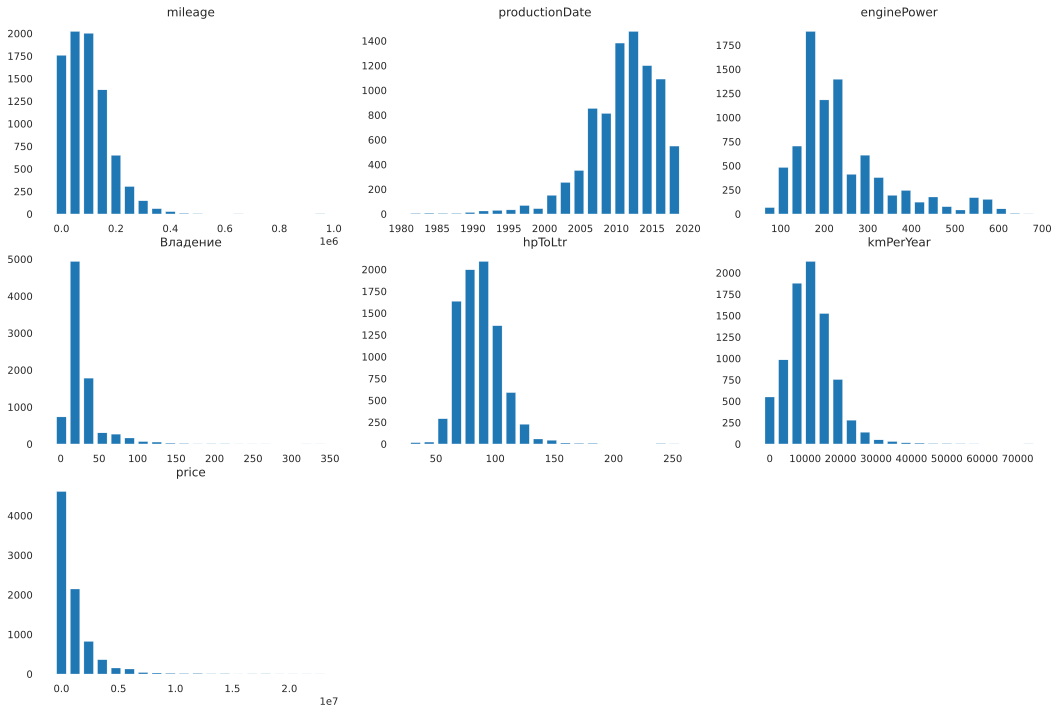

In [16]:
# Посмотрим, как выглядят распределения числовых признаков

def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': data['mileage'],
    'productionDate': data['productionDate'],
    'enginePower': data['enginePower'],
    'Владение': data['Владение'],
    'hpToLtr': data['hpToLtr'],
    'kmPerYear': data['kmPerYear'],
    'price': data['price'],
 
})

In [17]:
# ################### Numerical Features ############################################################## 
# Приближаем распределение к более нормальному
#for column in numerical_features:
#    data[column] = np.log1p(data[[column]])
#    data[column] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(data[[column]])
#    data[column] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[[column]])
#data['mileage'] = data['mileage'].apply(lambda x: np.log1p(x))
#data['mileage'] = PowerTransformer(method='box-cox', standardize=False).fit_transform(data[['mileage']])
#data['mileage'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['mileage']])
#data['productionDate'] = data['productionDate'].apply(lambda x: np.log1p(x))
#data['productionDate'] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(data[['productionDate']])
#data['productionDate'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['productionDate']])
#data['enginePower'] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(data[['enginePower']])
#data['enginePower'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['enginePower']])
#data['Владение'] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(data[['Владение']])
#data['Владение'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['Владение']])
#data['hpToLtr'] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(data[['hpToLtr']])
#data['hpToLtr'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['hpToLtr']])
#data['kmPerYear'] = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(data[['kmPerYear']])
#data['kmPerYear'] = QuantileTransformer(n_quantiles=1000, output_distribution='normal').fit_transform(data[['kmPerYear']])
# Нормализуем данные
for column in numerical_features:
    data[column] = MinMaxScaler().fit_transform(data[[column]])

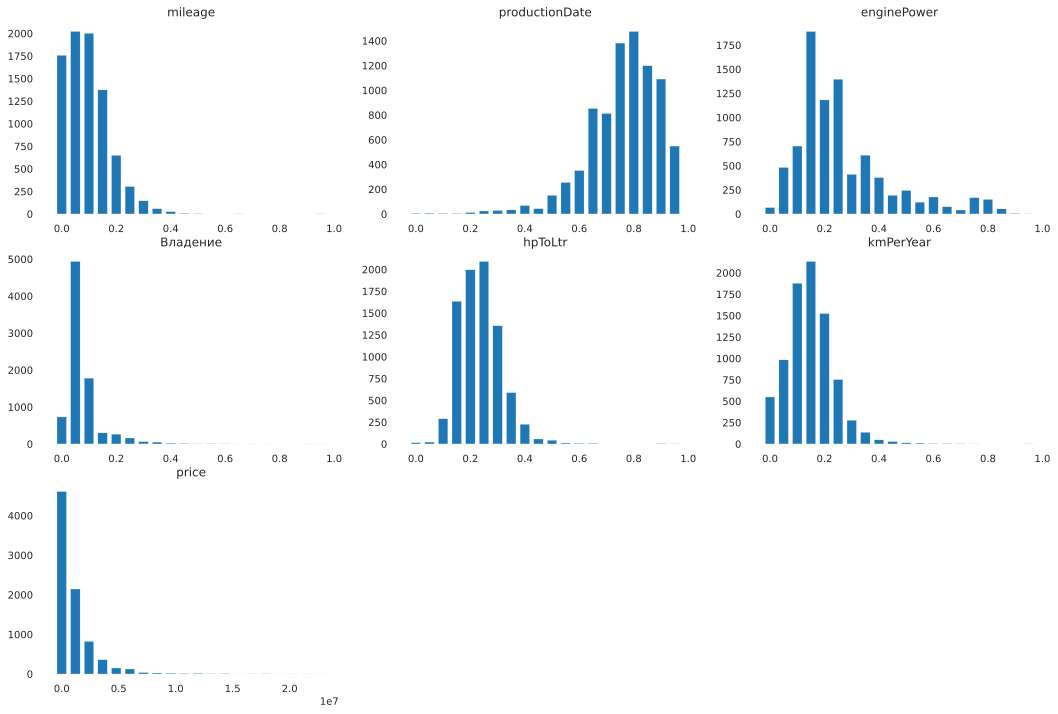

In [18]:
# Посмотрим, как теперь выглядят распределения числовых признаков
visualize_distributions({
    'mileage': data['mileage'],
    'productionDate': data['productionDate'],
    'enginePower': data['enginePower'],
    'Владение': data['Владение'],
    'hpToLtr': data['hpToLtr'],
    'kmPerYear': data['kmPerYear'],
    'price': data['price'],
 })

In [19]:
#sns.pairplot(data[numerical_features], corner=True, kind='scatter')

In [20]:
# ################### Categorical Features ############################################################## 
# Label Encoding
for column in categorical_features:
    data[column] = data[column].astype('category').cat.codes       
# One-Hot Encoding
data = pd.get_dummies(data, columns=categorical_features, dummy_na=True)

# Разделение данных на трейн и тест

In [21]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample', 'description', 'sell_id', ], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'description', 'sell_id', ], axis=1)

y = train_data.price.values
#y = np.log1p(train_data.price.values)
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

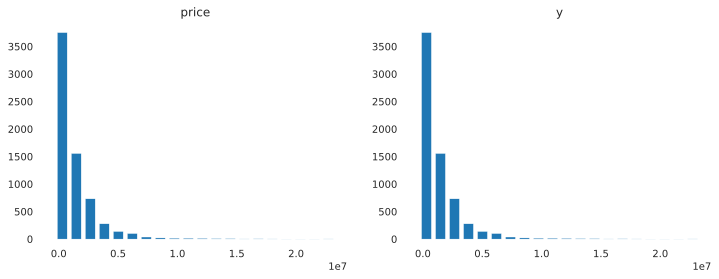

In [22]:
visualize_distributions({
    'price': train_data.price.values,
    'y': y,
})

# Model 2: CatBoostRegressor

## Single Model

Построим и сделаем предсказание на табличных данных с помощью библиотеки CatBoost.

### Model

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=RANDOM_SEED)

In [24]:
model = CatBoostRegressor(iterations = 12000,
                          random_seed = RANDOM_SEED,
                          eval_metric = 'MAPE',
                          od_wait = 500,
                         )
model.fit(X_train, y_train,
          eval_set = (X_test, y_test),
          use_best_model = True,
          plot = True,
          silent = True,
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Test

In [25]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, (np.round(test_predict_catboost)/1000)*1000))*100:0.2f}%")
#print(f"TEST mape: {(mape(np.expm1(y_test), np.round((np.expm1(test_predict_catboost)/1000)*1000)))*100:0.2f}%")

TEST mape: 13.39%


### Submission

In [26]:
sub_predict_catboost = model.predict(X_sub)
#sub_predict_catboost = np.expm1(sub_predict_catboost)
sample_submission['price'] = sub_predict_catboost
sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x/1000)*1000)
sample_submission.to_csv('catboost_submission.csv', index=False)

In [27]:
sample_submission['price']

0        457000
1       2258000
2        627000
3        449000
4       2777000
         ...   
1666    1083000
1667    2687000
1668    1550000
1669    1224000
1670    1090000
Name: price, Length: 1671, dtype: int64

# Model 3: MLP NN + NLP NN

In [28]:
data.description.sample(5)

7399    Авто в одних руках,все обслуживание  по реглам...
4273    Год выпуска 2016, приобрел новую без пробега в...
3362    В идеальном состоянии. Обслуживание в Панавто ...
2794    Эксклюзивный Audi A6, модельный ряд 2012 года....
5378    CОСТОЯНИЕ КАК У НОВОГО АВТОМОБИЛЯ !!! ОЧЕНЬ НА...
Name: description, dtype: object

### Подготовка текста

In [29]:
# Разбиваем на предложения
from nltk.tokenize import sent_tokenize, word_tokenize

data.description = data.description.apply(lambda x: sent_tokenize(x, language="russian"))
data.description.iloc[40]

['РОЛЬФ - Официальный дилер и Лучший дилер России по итогам продаж и обслуживания автомобилей.',
 'Мы гарантируем Вам самые лучшие условия покупки!',
 'Все автомобили прошли:\n\n∙ Криминалистическую и юридическую проверку.',
 '∙ Комплексную диагностику, Вы получаете лист с официальным заключением о состоянии автомобиля.',
 'Более 6 000 проверенных автомобилей с пробегом с гарантией до 2 лет ждут Вас на сайте rolf-probeg и в мобильном приложении Мой РОЛЬФ']

In [30]:
# Ищем и удаляем наиболее часто повторяющиеся предложения.

all_sentences = data.description.to_list()
flat_all_sentences = [item for sublist in all_sentences for item in sublist]
df_sent = pd.DataFrame({'Sentences': flat_all_sentences}) 
most_common = df_sent.value_counts()[:20].index.tolist()
most_common = [item for sublist in most_common for item in sublist]
most_common

['!',
 'Более 6 000 проверенных автомобилей с пробегом с гарантией до 2 лет ждут Вас на сайте rolf-probeg и в мобильном приложении Мой РОЛЬФ',
 'Своевременное обслуживание.',
 'Непрокуренный салон.',
 'Пройдены все ТО.',
 'До 150 000р.',
 'Внимание!',
 'Только для клиентов AVILON Автомобили с пробегом мы предлагаем специальную кредитную программу «Гарантия минимального ежемесячного платежа».',
 'Гарантия юридической чистоты.',
 'Куплена не в кредит.',
 'Позвоните нам и все узнайте подробнее!',
 '•\tОбязательная юридическая проверка автомобиля, что обеспечивает полную прозрачность сервисной истории и исключает наличие финансового обременения.',
 'Условия кредитования:\n• Первоначальный взнос от 30%.',
 '• Размер процентной ставки после снижения/перерасчета в конце срока кредита 9,9%.',
 '• Срок кредита – до 72 месяцев (до 6 лет).',
 'при обмене своего автомобиля на наш по системе trade-in\n2.',
 'Увеличенная дополнительная скидка:\n1.',
 'при оформлении кредита по сниженной ставки от ба

In [31]:
descriptions = data.description.values
for i in range(len(descriptions)):
  descriptions[i] = ['MASK' if token in most_common else token for token in descriptions[i]]
data['description'] = descriptions
    
data.description.iloc[40]

['РОЛЬФ - Официальный дилер и Лучший дилер России по итогам продаж и обслуживания автомобилей.',
 'Мы гарантируем Вам самые лучшие условия покупки!',
 'Все автомобили прошли:\n\n∙ Криминалистическую и юридическую проверку.',
 '∙ Комплексную диагностику, Вы получаете лист с официальным заключением о состоянии автомобиля.',
 'MASK']

In [32]:
data.description = data.description.apply(lambda x: ''.join([str(elem) for elem in x])) 
data.description.iloc[40]

'РОЛЬФ - Официальный дилер и Лучший дилер России по итогам продаж и обслуживания автомобилей.Мы гарантируем Вам самые лучшие условия покупки!Все автомобили прошли:\n\n∙ Криминалистическую и юридическую проверку.∙ Комплексную диагностику, Вы получаете лист с официальным заключением о состоянии автомобиля.MASK'

In [33]:
data.description = data.description.apply(lambda x: word_tokenize(x, language="russian"))
display(len(data.description.iloc[40]))

42

In [34]:
# Исключаем стоп-слова

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words("russian")

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

descriptions = data.description.values
for i in range(len(descriptions)):
  descriptions[i] = [morph.parse(token)[0].normal_form for token in descriptions[i] if not token in stop_words]
data['description'] = descriptions

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
display(len(data.description.iloc[40]))

36

In [36]:
data.description = data.description.apply(lambda x: ' '.join([str(elem) for elem in x])) 
data.description.iloc[40]

'рольф - официальный дилер хороший дилер россия итог продажа обслуживание автомобилей.м гарантировать вы самый хороший условие покупка ! всё автомобиль пройти : ∙ криминалистический юридический проверку.∙ комплексный диагностик , вы получать лист официальный заключение состояние автомобиля.mask'

### Подготовительные операции

In [37]:
# Глобальные переменные для TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [38]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [39]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [40]:
tokenize.word_index

{'•': 1,
 'автомобиль': 2,
 'система': 3,
 'задний': 4,
 'сидение': 5,
 'салон': 6,
 'пробег': 7,
 'передний': 8,
 'машина': 9,
 'состояние': 10,
 'год': 11,
 'комплект': 12,
 'диск': 13,
 '2': 14,
 'новый': 15,
 'ваш': 16,
 'официальный': 17,
 'фара': 18,
 'авто': 19,
 'дилер': 20,
 'пакет': 21,
 'руль': 22,
 'безопасность': 23,
 'колесо': 24,
 'комплектация': 25,
 'птс': 26,
 'контроль': 27,
 'в': 28,
 'кредит': 29,
 'зеркало': 30,
 'bmw': 31,
 'продажа': 32,
 'водитель': 33,
 'датчик': 34,
 'шина': 35,
 'ть': 36,
 'обмен': 37,
 'пассажир': 38,
 'полный': 39,
 'м': 40,
 'гарантия': 41,
 'отличный': 42,
 "''": 43,
 'двигатель': 44,
 '000': 45,
 'покупка': 46,
 'подушка': 47,
 'вы': 48,
 'технический': 49,
 'владелец': 50,
 'резина': 51,
 'подогрев': 52,
 'с': 53,
 'кузов': 54,
 'км': 55,
 'обогрев': 56,
 'проверка': 57,
 '3': 58,
 '1': 59,
 'то': 60,
 'хороший': 61,
 'оригинал': 62,
 'торг': 63,
 'масло': 64,
 'стекло': 65,
 'два': 66,
 'всё': 67,
 'ключ': 68,
 'по': 69,
 '»': 70,
 '«

In [41]:
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5345, 256) (1337, 256) (1671, 256)


In [42]:
print(text_train.iloc[40])
print(text_train_sequences[40])

рольф - официальный дилер хороший дилер россия итог продажа обслуживание автомобилей.м гарантировать вы самый хороший условие покупка ! всё автомобиль пройти : ∙ криминалистический юридический проверку.∙ комплексный диагностик , вы получать лист официальный заключение состояние автомобиля.mask
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

### MLP

In [43]:
model_mlp = tf.keras.Sequential(
    [
        tf.keras.Input(shape = X_train.shape[1]),
        L.Dense(194, activation="relu", ),
        L.Dropout(0.5),
        L.Dense(87, activation="relu", ),
        L.Dropout(0.5),
    ]
)

### NLP

In [44]:
model_nlp = tf.keras.Sequential(
    [
        tf.keras.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
        L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
        L.LSTM(256, return_sequences=True),
        L.Dropout(0.5),
        L.LSTM(128,),
        L.Dropout(0.25),
        L.Dense(64, activation="relu"),
        L.Dropout(0.25),
    ]
)

### Multiple Inputs NN

In [45]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])

head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [46]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     7295232     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [47]:
optimizer1 = tf.keras.optimizers.Adam(lr=1e-2)
optimizer2 = tfa.optimizers.RectifiedAdam(lr=1e-2)

model.compile(loss='MAPE',optimizer=optimizer1, metrics=['MAPE'])

In [48]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor='val_MAPE', verbose=0  , mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=50,)
callbacks_list = [
    checkpoint, 
#    earlystop,
]

In [49]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=1000,
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )

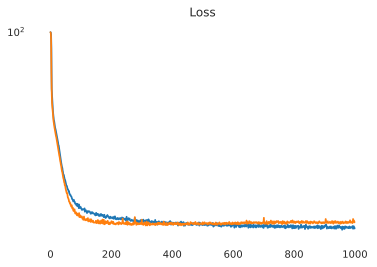

In [50]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.yscale("log")
plt.show();

### Test

In [51]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn.hdf5')

In [52]:
test_predict_nn = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, (np.round(test_predict_nn[:,0])/1000)*1000))*100:0.2f}%")
#print(f"TEST mape: {(mape(np.expm1(y_test), np.round((np.expm1(test_predict_nn[:,0])/1000)*1000)))*100:0.2f}%")

TEST mape: 12.34%


### Submission

In [53]:
sub_predict_nn = model.predict([text_sub_sequences, X_sub])
#sub_predict_nn[:,0] = np.expm1(sub_predict_nn[:,0])
sample_submission['price'] = sub_predict_nn[:,0]
sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x/1000)*1000)
sample_submission.to_csv('nn_submission.csv', index=False)

In [54]:
sample_submission['price']

0        485000
1       2800000
2        554000
3        523000
4       2980000
         ...   
1666    1021000
1667    2860000
1668    1560000
1669    1166000
1670    1129000
Name: price, Length: 1671, dtype: int64

# Blend

In [55]:
blend_predict = (test_predict_catboost + test_predict_nn[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")
#print(f"TEST mape: {(mape(np.expm1(y_test), np.expm1(blend_predict)))*100:0.2f}%")

TEST mape: 11.90%


In [56]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x/1000)*1000)
sample_submission.to_csv('blend_submission.csv', index=False)

In [57]:
sample_submission['price']

0        471000
1       2529000
2        591000
3        486000
4       2879000
         ...   
1666    1052000
1667    2774000
1668    1555000
1669    1195000
1670    1109000
Name: price, Length: 1671, dtype: int64